<a href="https://colab.research.google.com/github/phantom-balance/HybridEnergy/blob/master/solar_battery_gasifier_PO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PRE-RUN

In [1]:
from IPython.display import clear_output
!pip install pymoo
!pip install brewer2mpl
!pip install matplotlib
clear_output()

In [2]:
import matplotlib.pyplot as plt
# Set the global font and text parameters for plots
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams['font.size'] = 16
plt.rcParams['text.color'] = 'black'

# Function to set the plot style
def set_plot_style(ax):
    # Set the border color to black
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
# Set linewidth for spines
    ax.spines['top'].set_linewidth(1.3)
    ax.spines['bottom'].set_linewidth(1.3)
    ax.spines['left'].set_linewidth(1.3)
    ax.spines['right'].set_linewidth(1.3)

    # Set tick color and width
    ax.tick_params(axis='both', direction='in', width=1.5, colors='black')

In [3]:
# import necessary libraries
import pandas as pd
import numpy as np
import pymoo
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
# reading the hourly energy csv file "contains hourly data for deficits, solar radiation and ambient air temperature(Jumla)"
df = pd.read_csv('HOURLY_DATA_new.csv')
df = df[0:500]
'''
     csv file has deficit energy in MWh, solar radiation(ghi) in W/m2, air temperature in celcius.
    We perform the analysis in terms of KW.
'''
df['deficit_energy']=df['deficit_energy']*1000
df['deficit_energy'] = df['deficit_energy'].apply(lambda x: round(x, 6))
df['ghi']=df['ghi']/1000

'''
    All the necessary constants required for modeling.
'''
N = 20 # project_life
i = 0.06 # interest_rate

solar_cost_unit = 727 # usd/kW(capex)
solar_OM = 4 # usd/kW.year(opex)

CRF = (i*((1+i)**N))/(((1+i)**N)-1) # capital recovery factor
d_f = 0.88 #derating_factor
Gt_stc = 1 #kw/m2
ap = -0.0035 #solar mod temp coeff of power(%/oC)
T_cstc = 25 #oC standard temp
NOCT = 45 #oC
n_bat = 0.92 #round trip efficieny

gasifier_cost_unit = 2300 # usd/kW(capex)
gasifier_OM = 2 # usd/kW.year(opex)
gasifier_CUF = 0.55 # capacity utilization factor

battery_cost_unit = 145 # usd/kWh(capex)
battery_OM_per = 1.5 # 1.5% of capex annuity(opex)

'''
    Calculating the Annualized system cost(ASC) and the levelised cost of energy(LCOE)
'''
def cost_pv(solar):
  solar_cost = solar*((CRF*solar_cost_unit)+solar_OM)
  return solar_cost

def cost_gasifier(gasifier):
  gasifier_cost = gasifier*((CRF*gasifier_cost_unit)+gasifier_OM)
  return gasifier_cost

def cost_battery(battery):
  battery_cap = battery*battery_cost_unit
  battery_op = battery_cap*CRF*battery_OM_per/100
  battery_cost = battery_cap*CRF+battery_op
  return battery_cost

def LCOE(total_energy_prod, solar, gasifier, battery):
  ASC = cost_pv(solar)+cost_gasifier(gasifier)+cost_battery(battery)
  energy_prod_per_year = total_energy_prod/N
  lcoe = ASC/(energy_prod_per_year)
  return ASC, lcoe

'''
    Calculating the energy produced by the solar panel and gasifier.
'''
def solar_ene_prod(solar_rate, solar_rad, temp):
  T_cell = temp+Gt_stc*((NOCT-20)/0.8)
  p_op = solar_rate*d_f*(solar_rad/Gt_stc)*(1+ap*(T_cell-T_cstc))
  return p_op

def gasifier_ene_prod(gasifier_rate):
  return gasifier_rate*gasifier_CUF

'''
    Hybrid Energy system operational strategy
'''
def Energy_prod_(energy_def, battery_E, battery_max, solar_rate, solar_rad, gasifier_rate, temp):
  energy_def=-energy_def
  energy_prod = 0
  energy_served = 0
  solar_energy = 0
  gasifier_energy = 0
  battery_E_up = battery_E
  battery_supply = 0
  solar_energy = solar_ene_prod(solar_rate, solar_rad, temp)

  if energy_def>0:
    '''
    Energy deficit strategy
    '''
    if solar_energy-energy_def<0:
      '''
      Solar cannot fulfill the energy deficit.
      Run battery and gasifier.
      '''
      # req_energy needs to be addressed by gasifier and battery
      req_energy = energy_def-solar_energy
      energy_served+=solar_energy

      if battery_E>battery_max*0.3:
        if req_energy<=(battery_E-battery_max*0.3):
          '''
          req_energy met by only battery
          '''
          battery_supply = req_energy
          battery_E_up = battery_E-req_energy
          energy_served+=battery_supply

        else:
          '''
          req_energy met by battery and gasifier
          '''
          gasifier_E_req = req_energy-(battery_E-battery_max*0.3)
          battery_supply = battery_E-0.3*battery_max
          energy_served+=battery_supply
          battery_E_up = 0.3*battery_max
          gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

          if gasifier_energy_op>gasifier_E_req:
            gasifier_energy = gasifier_E_req
            energy_served+=gasifier_energy

          else:
            pass
            '''
            Hybrid energy system cannot fulfill the energy deficit.
            New hybrid combination required.
            '''
            # print("# THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")

      else:
        '''
        req_energy met only by gasifier
        '''
        gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

        if req_energy<gasifier_energy_op:
          gasifier_energy = req_energy
          energy_served+=gasifier_energy
        else:
          pass
          '''
          Hybrid energy system cannot fulfill the energy deficit.
          New hybrid combination required.
          '''
          # print("THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")

    else:
      '''
      Solar can fulfill the energy deficit.
      Extra energy from the solar panel is used to charge the battery.
      '''
      energy_served+=energy_def # solar panel served the entire deficit energy
      Pch_t = solar_energy-energy_def # extra energy from solar used for charging battery
      Ech_t = Pch_t*n_bat

      if Ech_t<=battery_max-battery_E:
        #battery isn't fully charged
        battery_E_up = battery_E+Ech_t

      else:
        #battery gets fully charged, E_dump is the remaining energy served to the grid
        battery_E_up = battery_max
        E_dump = Ech_t - (battery_max-battery_E)
        energy_served+=(E_dump/n_bat)
        Ech_t = battery_max-battery_E

    energy_prod = solar_energy + gasifier_energy

  else :
    '''
    Energy surplus strategy
    '''
    energy_prod=solar_energy+gasifier_energy
    surplus_ene = abs(energy_def)

    Pch_t = solar_energy
    Ech_t = Pch_t*n_bat

    if Ech_t<=battery_max-battery_E:
      battery_E_up = battery_E+Ech_t

    else:
      battery_E_up = battery_max
      E_dump = Ech_t - (battery_max-battery_E)
      energy_served+=(E_dump/n_bat)
      Ech_t = battery_max-battery_E

  return energy_served, battery_supply, battery_E_up, solar_energy, gasifier_energy
'''
    Optimization for minimizing the LCOE.
'''
class ProblemWrapper(Problem):
  def _evaluate(self, designs, out, *args, **kwargs):
    res = []
    res1 =[]
    for design in designs:

      solar, gasifier, battery = design

      count = 0
      Energy_prod_N = 0 #total energy throughout the project life produced
      battery_E = battery

      for i in range(len(df)):
        n_battery_E = battery_E
        Energy_served,battery_supply, battery_E, _, _ = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
        Energy_prod_N += Energy_served
        energy_tot = df['deficit_energy'][i]+Energy_served
        energy_tot = round(energy_tot, 4)

        if energy_tot<0 and count!=1:
          count = 1
          break

      asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
      res.append(lcoe)
      res1.append(count)
    out['F']=np.array(res)
    out['H']=np.array(res1)

problem = ProblemWrapper(n_var=3, n_obj=1, n_eq_constr=1, xl=[0, 0, 0], xu=[7440937, 2360000, 7440937],vtype=int)
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
algorithm = GA(pop_size=2,
               sampling=IntegerRandomSampling(),
               crossover=SBX(prob=1.0, eta=3.0, vtype=int, repair=RoundingRepair()),
               mutation=PM(prob=1.0, eta=3.0, vtype=int, repair=RoundingRepair()),
               eliminate_duplicate=True)
stop_criteria = ('n_gen', 5)
results = minimize(problem=problem,
                   algorithm=algorithm,
                   termination=stop_criteria,
                   verbose=True,
                   seed=42,
                   save_history=True)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |        2 |  0.000000E+00 |  0.000000E+00 |  3.893767E+01 |  3.678131E+01
     2 |        4 |  0.000000E+00 |  0.000000E+00 |  3.689388E+01 |  3.678131E+01
     3 |        6 |  0.000000E+00 |  0.000000E+00 |  3.609134E+01 |  3.554374E+01
     4 |        8 |  0.000000E+00 |  0.000000E+00 |  3.540217E+01 |  3.526060E+01
     5 |       10 |  0.000000E+00 |  0.000000E+00 |  3.540217E+01 |  3.526060E+01


In [4]:
inv_cost_unit = 300 # usd/kW(capex)
inv_OM = 1 # usd/kW.year(opex)
# inv_cap = np.array(solar_ene_array).max()
def cost_inv(inv):
  inv_cost = inv*((CRF*inv_cost_unit)+inv_OM)
  return inv_cost

N=20
def LCOE_inv(total_energy_prod, inv_cap):
  ASC_inv = cost_inv(inv_cap)
  energy_prod_per_year = total_energy_prod/N
  lcoe_inv = ASC_inv/(energy_prod_per_year)
  return lcoe_inv

# POST OPTIMIZATION

In [5]:
import pickle
with open('pv-gas-bat_ga-res.pkl', 'rb') as file:
    results_bat = pickle.load(file)

df = pd.read_csv('HOURLY_DATA_new.csv')
df = df[0:24*365*20]
df['deficit_energy']=df['deficit_energy']*1000
df['deficit_energy'] = df['deficit_energy'].apply(lambda x: round(x, 6))
df['ghi']=df['ghi']/1000

In [6]:
solar, gasifier, battery = results_bat.X

solar_array = []
gasifier_array = []
battery_array = []
battery_supply_array = []
deficit_array = []

total_supply = []

count = 0
gasifier_up_hr = 0
gasifier_energy_tot = 0
battery_energy_tot = 0
solar_energy_tot = 0
Energy_prod_N = 0
battery_E = battery
solar_ene_array = []
for i in range(len(df)):
# for i in range(8760):

  # Energy_produced = Energy_prod(solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_served, battery_supply, battery_E, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_prod_N += Energy_served
  gasifier_energy_tot+=gasifier_ene
  battery_energy_tot+=battery_supply
  solar_ene_served = Energy_served-gasifier_ene-battery_supply
  solar_energy_tot+=solar_ene_served
  solar_ene_array.append(solar_ene)


  if round(gasifier_ene, 2)>0:
    # print(gasifier_ene)
    # print(i)


    gasifier_up_hr+=1

  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  battery_supply_array.append(battery_supply)
  battery_array.append(battery_E)
  total_supply.append(battery_supply+gasifier_ene+solar_ene)
print(gasifier_up_hr)
print(gasifier_energy_tot)
asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
print(asc, lcoe)
ene_tot_bat = Energy_prod_N
print(Energy_prod_N)

11872
3399597914.8955574
985278675.6627448 0.08485805143453722
232218076895.821


In [7]:
yearly_solar = []
yearly_gasifier = []
yearly_battery = []
gasifier_n = 0
solar_n = 0
battery_n = 0
for i in range(len(df)):

  # Energy_produced = Energy_prod(solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_served, battery_supply, battery_E, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_prod_N += Energy_served
  gasifier_energy_tot+=gasifier_ene
  battery_energy_tot+=battery_supply
  solar_ene_served = Energy_served-gasifier_ene-battery_supply
  solar_energy_tot+=solar_ene_served
  solar_ene_array.append(solar_ene)

  gasifier_n += gasifier_ene
  battery_n += battery_supply
  if df['deficit_energy'][i]<0:
    solar_n += -df['deficit_energy'][i]-battery_supply-gasifier_ene
  else:
    solar_n += 0

  if i%8760==0 or i==175199:
    yearly_solar.append(solar_n)
    yearly_gasifier.append(gasifier_n)
    yearly_battery.append(battery_n)

    solar_n = 0
    gasifier_n = 0
    battery_n = 0


  if round(gasifier_ene, 2)>0:
    # print(gasifier_ene)
    # print(i)


    gasifier_up_hr+=1

  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  battery_supply_array.append(battery_supply)
  battery_array.append(battery_E)
  total_supply.append(battery_supply+gasifier_ene+solar_ene)

yearly_solar = yearly_solar[1:]
yearly_gasifier = yearly_gasifier[1:]
yearly_battery = yearly_battery[1:]

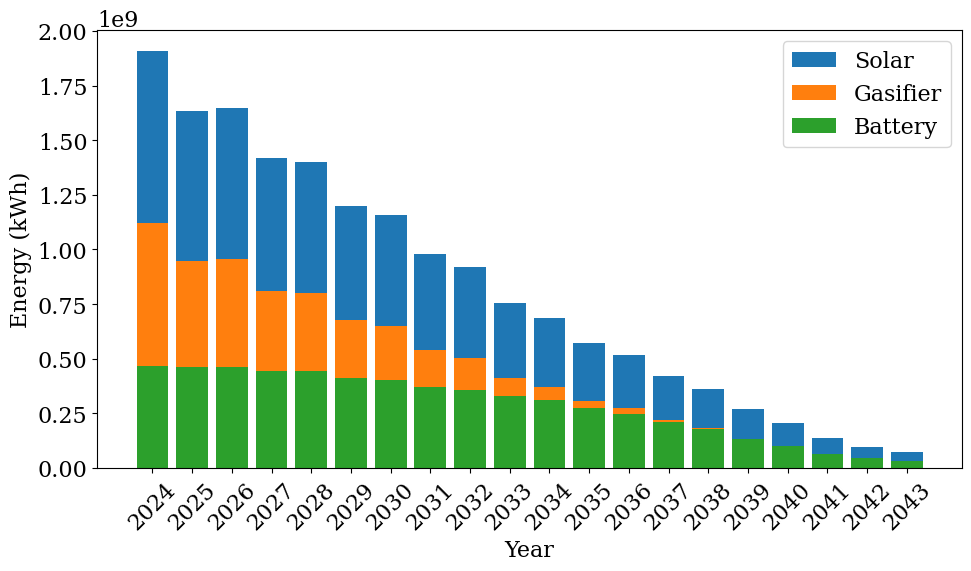

In [24]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Create the stacked bar chart
plt.bar(range(len(yearly_solar)), yearly_solar, label='Solar', bottom=[sum(x) for x in zip([0]*len(yearly_solar),yearly_gasifier, yearly_battery)])
plt.bar(range(len(yearly_gasifier)), yearly_gasifier, label='Gasifier', bottom=yearly_battery)
plt.bar(range(len(yearly_battery)), yearly_battery, label='Battery')

plt.xlabel("Year")
plt.ylabel("Energy (kWh)")
plt.legend()
# plt.legend(prop={'size': 18})

# Set xticks to years 2024-2043 and rotate them
plt.xticks(range(len(yearly_solar)), [str(i + 2024) for i in range(len(yearly_solar))], rotation=45)

plt.tight_layout()
plt.savefig('energy_bat.png', dpi=600)
plt.show()

In [ ]:
inv_cap_bat = np.array(solar_ene_array).max()
inv_bat_lcoe = LCOE_inv(ene_tot_bat, inv_cap_bat)
inv_bat_lcoe

0.015591056314095983

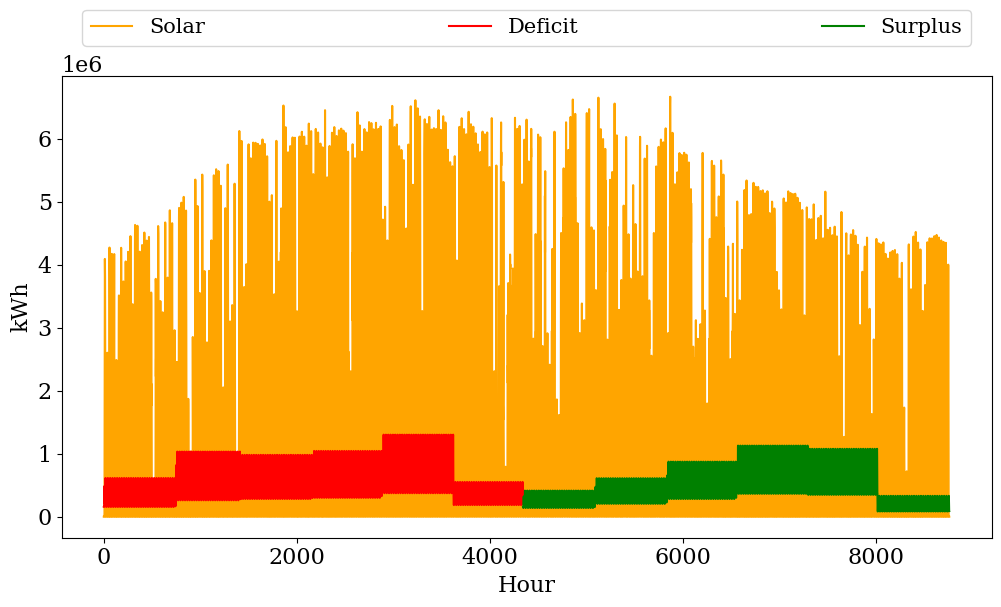

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ... (your existing code)

i = 0 # start hour
j = 8760 # end hour
x = np.arange(i, j)

fig, ax1 = plt.subplots(figsize=(12, 6))

# ... (rest of the plotting code without the twinx and second y-axis for battery SOC)

# Plotting on the first y-axis (left)
ax1.plot(x, solar_array[i:j], label='Solar', color='orange')
# ax1.plot(x, gasifier_array[i:j], label='Gasifier', color='blue')

# Separate plots for deficit and surplus
deficit_indices = np.where(np.array(deficit_array[i:j]) < 0)[0]
surplus_indices = np.where(np.array(deficit_array[i:j]) >= 0)[0]

ax1.plot(x[deficit_indices], -np.array(deficit_array[i:j])[deficit_indices], label='Deficit', color='red')
ax1.plot(x[surplus_indices], np.array(deficit_array[i:j])[surplus_indices], label='Surplus', color='green')


ax1.set_xlabel("Hour")
ax1.set_ylabel("kWh")


# Set the legend
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=1., prop={'size': 15}) # Increased ncol for the legend

plt.savefig("whole_year.png", dpi=600)
plt.show()

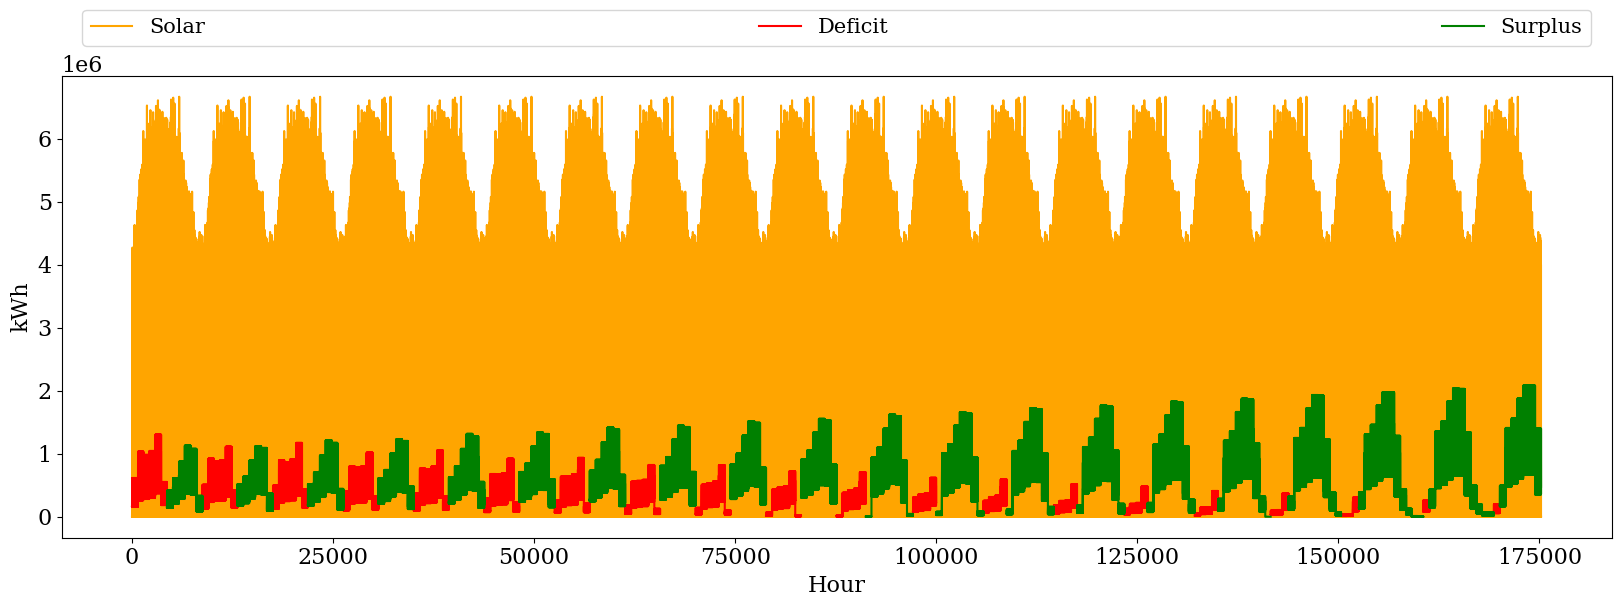

In [ ]:
i = 0 # start hour
j = 8760*20 # end hour
x = np.arange(i, j)

fig, ax1 = plt.subplots(figsize=(20, 6))

# ... (rest of the plotting code without the twinx and second y-axis for battery SOC)

# Plotting on the first y-axis (left)
ax1.plot(x, solar_array[i:j], label='Solar', color='orange')
# ax1.plot(x, gasifier_array[i:j], label='Gasifier', color='blue')

# Separate plots for deficit and surplus
deficit_indices = np.where(np.array(deficit_array[i:j]) < 0)[0]
surplus_indices = np.where(np.array(deficit_array[i:j]) >= 0)[0]

# Find the indices where deficit periods are separated by surplus periods
deficit_splits = np.where(np.diff(deficit_indices) > 1)[0]

# Plot deficit periods separately to avoid connecting lines between them
start = 0
for split in deficit_splits:
    ax1.plot(x[deficit_indices[start:split+1]], -np.array(deficit_array[i:j])[deficit_indices[start:split+1]], label='Deficit' if start == 0 else '', color='red')
    start = split + 1
ax1.plot(x[deficit_indices[start:]], -np.array(deficit_array[i:j])[deficit_indices[start:]], label='Deficit' if start == 0 else '', color='red')

#Plot surplus periods separately
surplus_splits = np.where(np.diff(surplus_indices) > 1)[0]
start = 0
for split in surplus_splits:
    ax1.plot(x[surplus_indices[start:split+1]], np.array(deficit_array[i:j])[surplus_indices[start:split+1]], label='Surplus' if start == 0 else '', color='green')
    start = split + 1

ax1.plot(x[surplus_indices[start:]], np.array(deficit_array[i:j])[surplus_indices[start:]], label='Surplus' if start == 0 else '', color='green')


ax1.set_xlabel("Hour")
ax1.set_ylabel("kWh")


# Set the legend
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=1., prop={'size': 15}) # Increased ncol for the legend

plt.savefig("whole_life_20yrs.png", dpi=600)
plt.show()

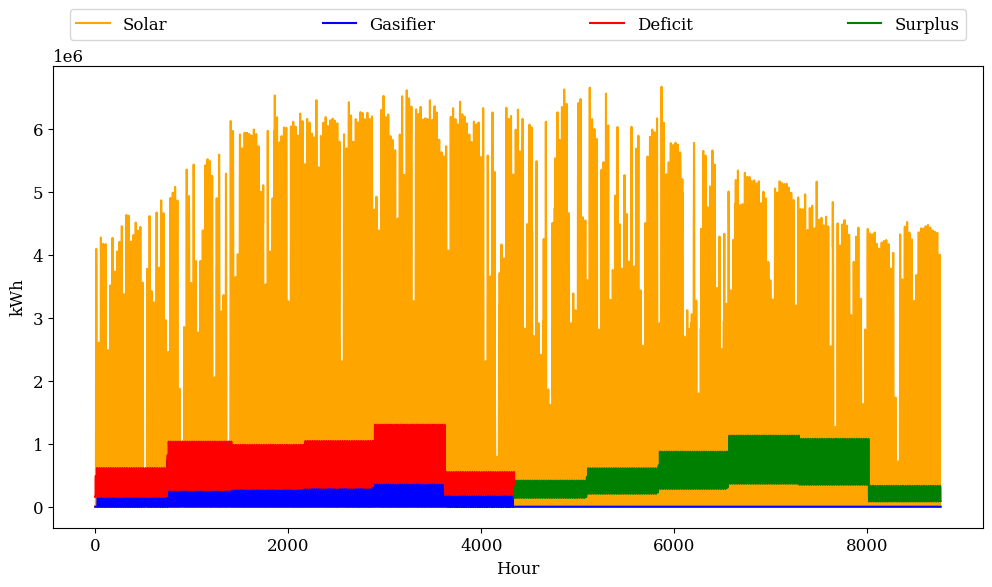

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ... (your existing code)

i = 0 # start hour
j = 8760  # end hour
x = np.arange(i, j)

fig, ax1 = plt.subplots(figsize=(12, 6))

# ... (rest of the plotting code without the twinx and second y-axis for battery SOC)

# Plotting on the first y-axis (left)
ax1.plot(x, solar_array[i:j], label='Solar', color='orange')
ax1.plot(x, gasifier_array[i:j], label='Gasifier', color='blue')

# Separate plots for deficit and surplus
deficit_indices = np.where(np.array(deficit_array[i:j]) < 0)[0]
surplus_indices = np.where(np.array(deficit_array[i:j]) >= 0)[0]

ax1.plot(x[deficit_indices], -np.array(deficit_array[i:j])[deficit_indices], label='Deficit', color='red')
ax1.plot(x[surplus_indices], np.array(deficit_array[i:j])[surplus_indices], label='Surplus', color='green')


ax1.set_xlabel("Hour")
ax1.set_ylabel("kWh")


# Set the legend
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=1.) # Increased ncol for the legend

plt.savefig("pv_bat_gas_whole_year.png", dpi=600)
plt.show()

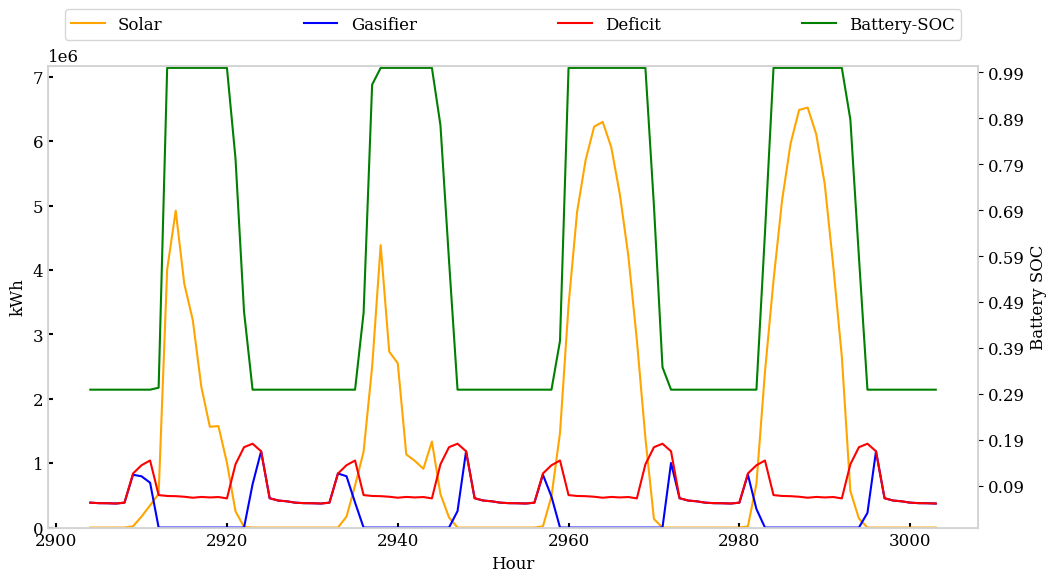

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

i = 2904 # start hour
j = 2904+100 # end hour
x = np.arange(i,j)

fig, ax1 = plt.subplots(figsize=(12, 6))

set_plot_style(plt.gca())
# ax = plt.gca()  # Get the current axes
ax1.spines['top'].set_color('lightgray')
ax1.spines['bottom'].set_color('lightgray')
ax1.spines['left'].set_color('lightgray')
ax1.spines['right'].set_color('lightgray')

# Plotting on the first y-axis (left)
ax1.plot(x, solar_array[i:j], label='Solar', color='orange')
ax1.plot(x, gasifier_array[i:j], label='Gasifier', color='blue')
ax1.plot(x, -np.array(deficit_array[i:j]), label='Deficit', color='red')
ax1.set_xlabel("Hour")
ax1.set_ylabel("kWh")


# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.spines['top'].set_color('lightgray')
ax2.spines['bottom'].set_color('lightgray')
ax2.spines['left'].set_color('lightgray')
ax2.spines['right'].set_color('lightgray')

normalized_battery = 0.7 * (np.array(battery_array[i:j]) - np.min(battery_array[i:j])) / (np.max(battery_array[i:j]) - np.min(battery_array[i:j])) + 0.3


# Plotting on the second y-axis (right)
ax2.plot(x, normalized_battery, label='Battery-SOC', color='green')
ax2.set_ylabel("Battery SOC")
ax2.set_ylim(0, 1.005) # Set the limit of the second y-axis
ax2.set_yticks(np.arange(0.09, 1.01, 0.1))

#Find the maximum value of solar and battery
max_solar = np.max(solar_array[i:j])
max_battery = np.max(normalized_battery)
ax1.set_ylim(0, max(max_solar, max_battery) * 1.1)  # Adjust y-limit based on maximum value


# Combining legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=5, mode="expand", borderaxespad=1.)
plt.savefig("BAT-operation.png", dpi=600)
plt.show()

In [ ]:
# asc pie chart
solar_asc = cost_pv(solar)
gasifier_asc = cost_gasifier(gasifier)
battery_asc = cost_battery(battery)
inv_bat_asc = cost_inv(inv_cap_bat)
print(solar, gasifier, battery, inv_cap_bat)
print(solar_asc, gasifier_asc, battery_asc, inv_bat_asc)

7440935 2154098 3711780 6666315.910271218
501393809.80763423 436257579.57385975 47627286.28125073 181026255.70169082


<Figure size 5000x4000 with 0 Axes>

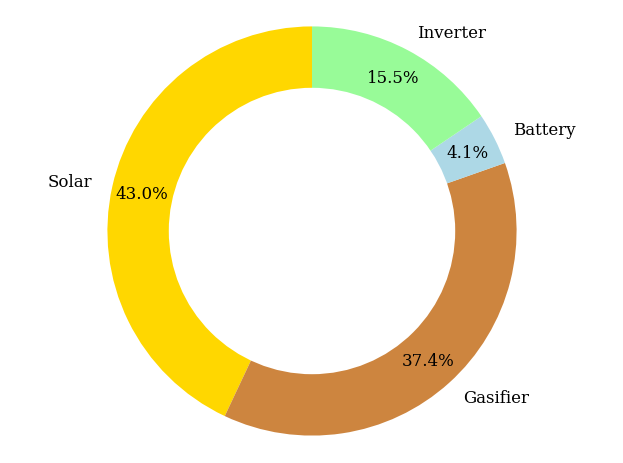

In [ ]:
# Data for the pie chart
labels = ['Solar', 'Gasifier', 'Battery', 'Inverter']
sizes = [solar_asc, gasifier_asc, battery_asc, inv_bat_asc]
colors = ['gold', 'peru', 'lightblue', 'palegreen']

# Create the pie chart with a hole in the middle
plt.figure(figsize=(10,8), dpi=500)
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a circle in the middle to create the donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
# plt.title('Annualized System Cost Components')
plt.tight_layout()
plt.savefig('bat_ASC.png', dpi=600)
plt.show()

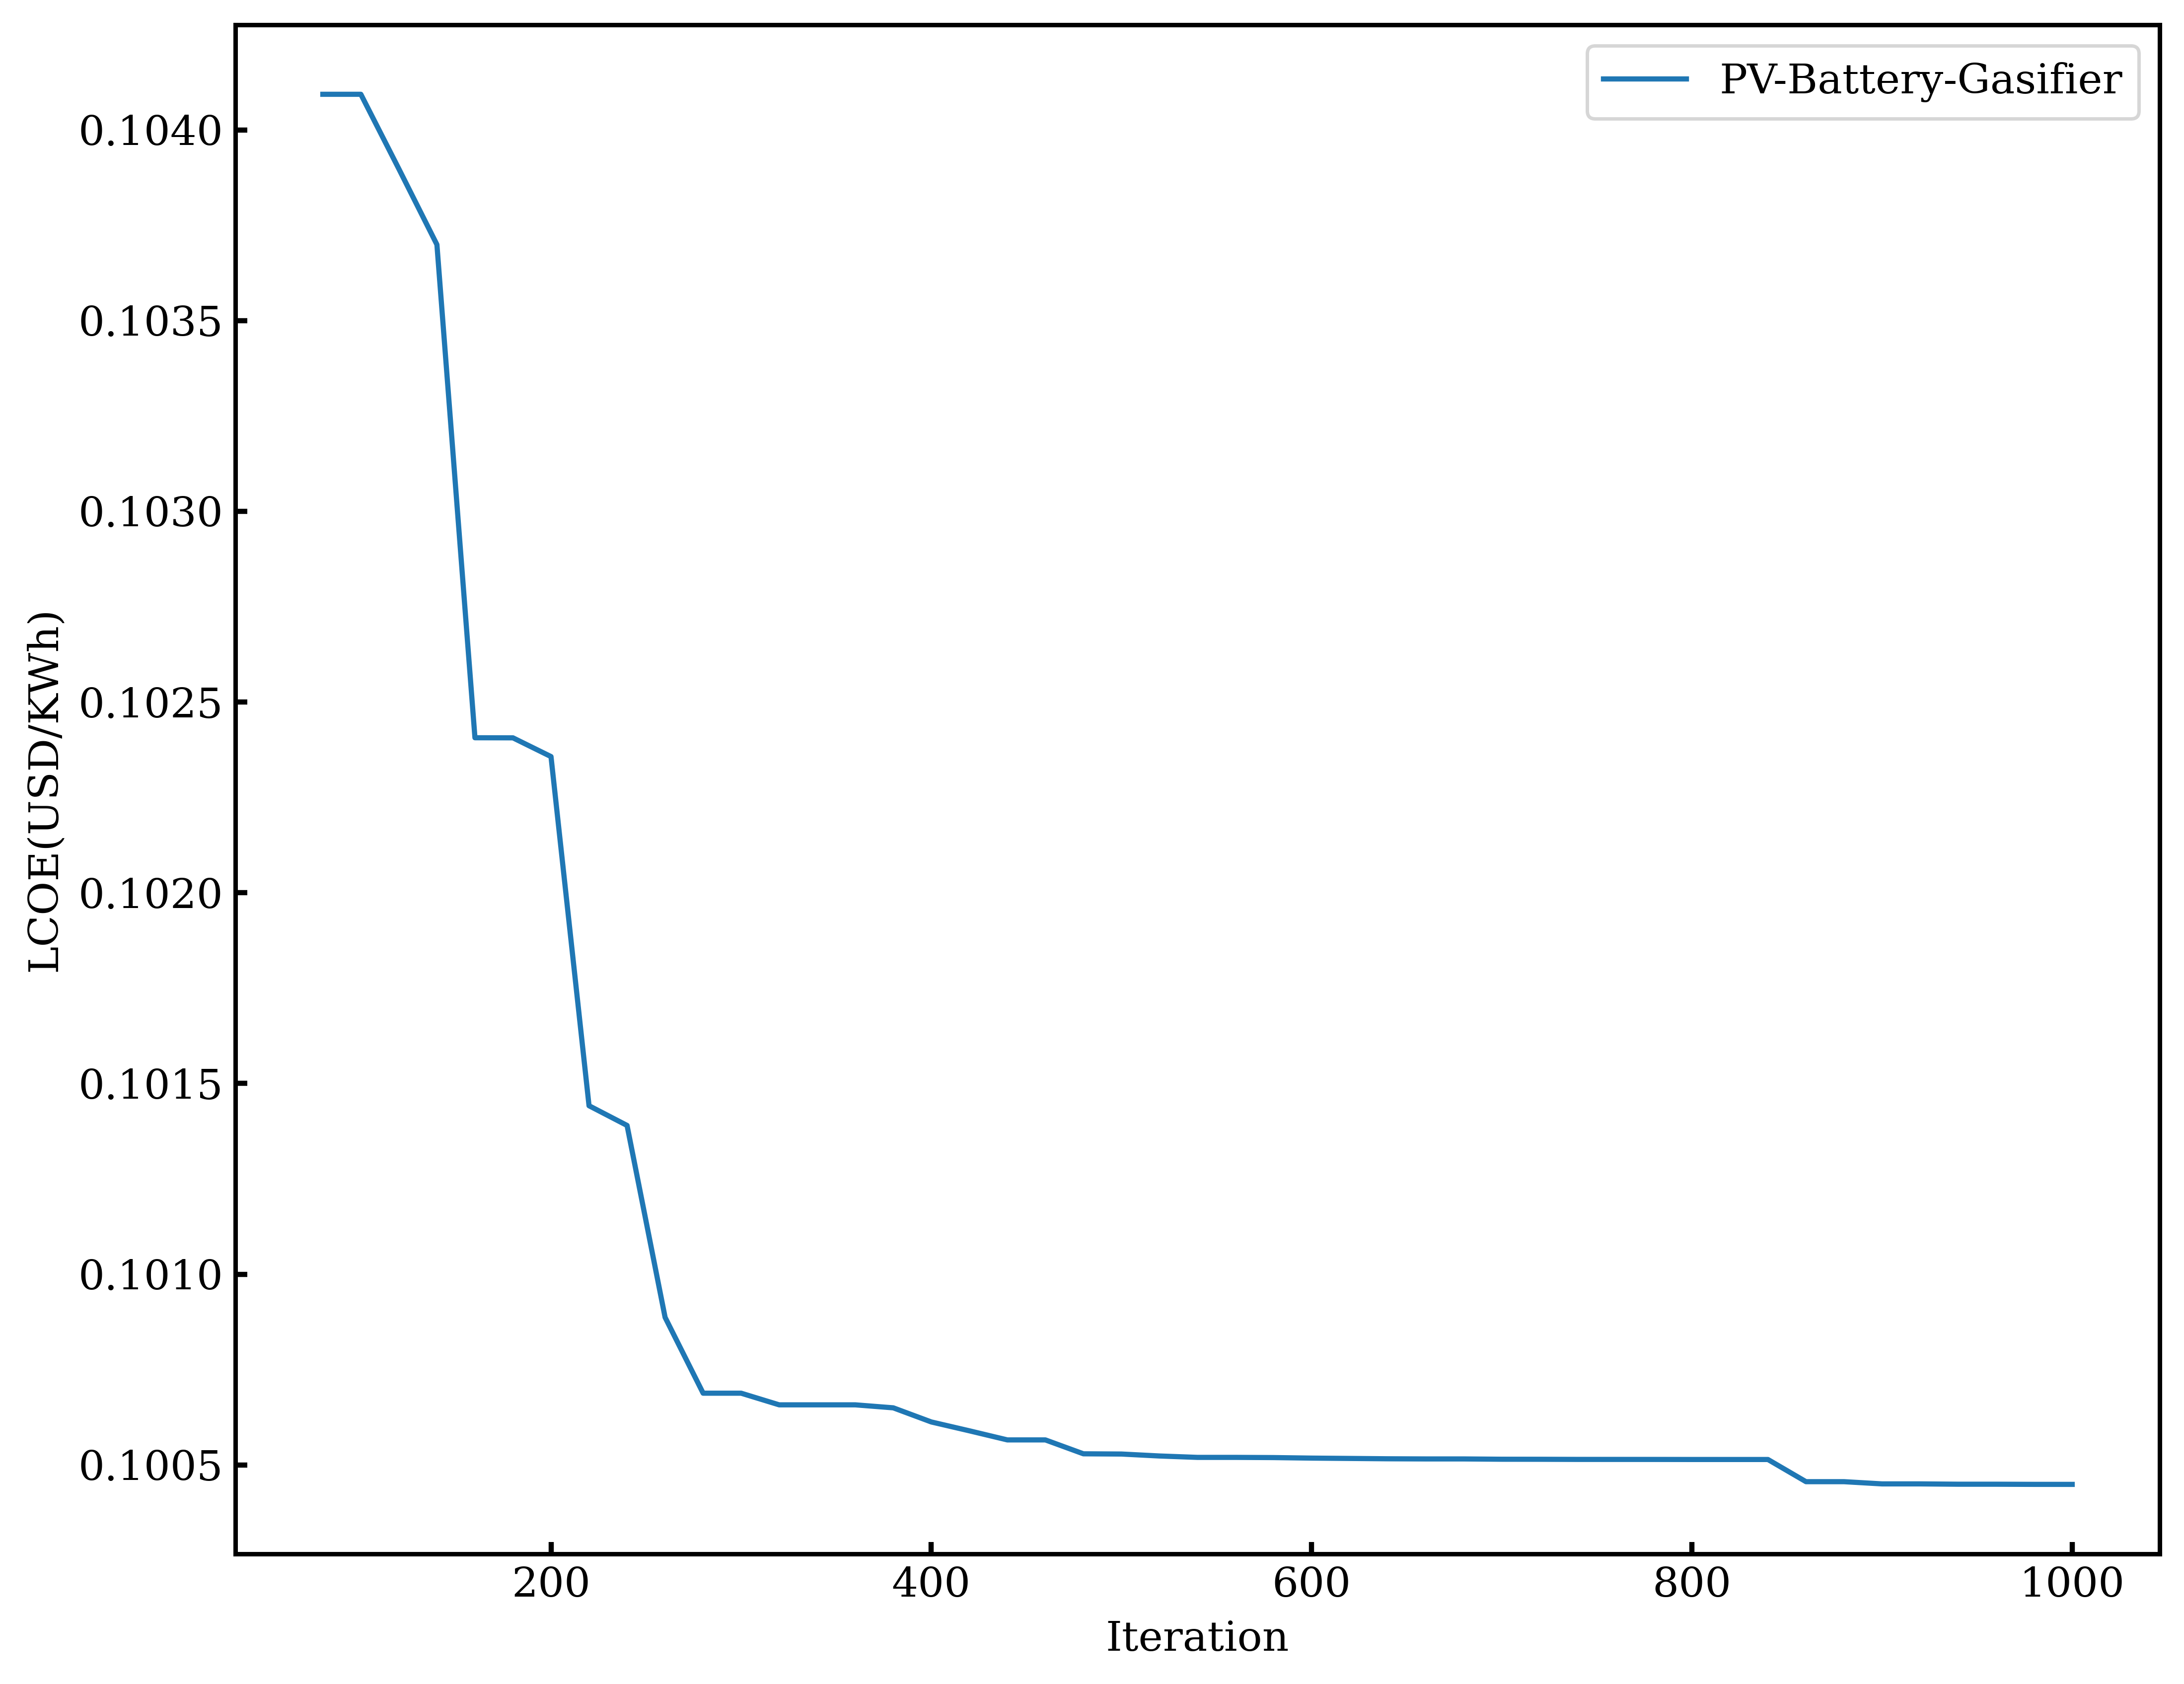

In [ ]:
'''
Convergence plot for SOO.
'''
import numpy as np
import matplotlib.pyplot as plt

# plt.title("Convergence")
plt.figure(figsize=(10,8), dpi=500)
plt.subplot(1,1,1)
set_plot_style(plt.gca())

# n_evals = np.array([e.evaluator.n_eval for e in results_phs.history])
# opt = np.array([e.opt[0].F for e in results_phs.history])
# plt.plot(n_evals[3:], opt[3:]+inv_phs_lcoe, label = "PV-PHS-Gasifier", linestyle="-")

# n_evals = np.array([e.evaluator.n_eval for e in results_p2h2p.history])
# opt = np.array([e.opt[0].F for e in results_p2h2p.history])
# plt.plot(n_evals[3:], opt[3:]+inv_p2h2p_lcoe, label = "PV-P2H2P-Gasifier", linestyle="-")

n_evals = np.array([e.evaluator.n_eval for e in results_bat.history])
opt = np.array([e.opt[0].F for e in results_bat.history])
plt.plot(n_evals[3:], opt[3:]+inv_bat_lcoe,label = "PV-Battery-Gasifier", linestyle="-")


plt.xlabel("Iteration")
plt.ylabel("LCOE(USD/KWh)")
plt.legend(loc='upper right')
# plt.savefig('phs_convergence.png')
# plt.savefig('battery_convergence.png')
plt.savefig('battery_convergence.png')
plt.show()